## **DataExplorer tutorial**

```DataExplorer()``` is a class created with intention of simplifying the daily fitting routine, which one is usually faced with while doing B-physics analyses.
The structure of the framework is pretty simple: 
* basic methods are implemented in ```DataExplorer()``` class:
    * unbinned or binned $\chi^2$-fitting
    * plotting of data and model on the frame
    * regions (e.g. signal/sideband) setting and plotting
    * writing/extracting from a RooWorkspace
    * **bonus**: fix_shapes() method to _automatically_ set and fix all the parameters of the model to the corresponding ones in the workspaces (these are usually the models one obtained from the MC simulation)
* additional fancy functionality for permorming statistical inference is added through ```StatTools()``` class, which is a parent of ```DataExplorer()```:
    * $\chi^2$ goodness-of-fit test
    * asymptotic methods for calculating signal significance
    * signal significance calculation by generating toys from bkgr only hypothesis and fitting with s+b model to obtain test statistic distribution
    * plotting of pull distribution $\frac{data - model}{error(data)}$ to verify fit quality
    * plotting likelihood profiles for a parameter of interest
    * checking of the bias in the fit by generating toys from the data, fitting and accumulating fit parameter values.
    
It is assumed that the communication between these two classes will be mostly through RooWorkspace() objects. It is not perpect and not implemented throughout consistently, so there is some room for improvement.

Some methods (e.g. ```extract_from_workspace()```) are made static for the sake of code's clarity. This therefore requires usage of ```@classmethod``` here and there to pass these methods up the inheritance tree to the ```StatTools()``` class.

For more details on the implementation please refer to the source code in this directory.

In [1]:
from DataExplorer import DataExplorer
import ROOT
from ROOT import RooFit as RF

ROOT.RooMsgService.instance().setSilentMode(True) # silencing the fit output
ROOT.RooMsgService.instance().setStreamStatus(1,False) # this might be way too quiet
ROOT.RooMsgService.instance().setGlobalKillBelow(RF.WARNING) # more silence

Welcome to JupyROOT 6.14/04


         ~~~




In [2]:
N_GEN = 1000 # number of events to generate
SIG_FRACTION = 0.1 # fraction of the signal component
chi2_results = {}

#### **Observable**

In [3]:
m = ROOT.RooRealVar("m", "mass [GeV]", 5.2, 5.3)
m.setBins(50)

#### **Parameters**

don't hesitate to tune them!

In [4]:
exp_par = ROOT.RooRealVar("exp_par", "#lambda", -5., -50, 1.) # parameter of the exponential background model
mean = ROOT.RooRealVar("mean", "mean [GeV]", 5.25, 5.2, 5.3) # mean of the signal Gaussian
sigma = ROOT.RooRealVar("sigma", "#sigma [GeV]", 0.005, 0.001, 0.05) # sigma of the signal Gaussian

fraction = ROOT.RooRealVar('fraction', 'fraction', SIG_FRACTION)  # used only for data generation here
N_sig = ROOT.RooRealVar('N_sig', 'N_{sig}', 100, 0, N_GEN)
N_bkgr = ROOT.RooRealVar('N_bkgr', 'N_{bkgr}', 1000., 0, N_GEN)

#### **PDFs**


and play with various models too!

In [5]:
sig = ROOT.RooGaussian("sig", "sig", m, mean, sigma) #  by convention signal component label should begin with 'sig' 
bkgr = ROOT.RooExponential("bkgr", "bkgr", m, exp_par) # and background - with 'bkgr'

for the sake of simplicity it's more convenient to use fraction model for generating events and controlling signal fraction:

In [6]:
model_gen = ROOT.RooAddPdf("model_gen", "model_gen", ROOT.RooArgList(sig, bkgr), ROOT.RooArgList(fraction)) 
model = ROOT.RooAddPdf('model', 'model', ROOT.RooArgList(sig, bkgr), ROOT.RooArgList(N_sig, N_bkgr))

#### **Sample N_GEN events**

In [7]:
data = model_gen.generate(ROOT.RooArgSet(m), N_GEN)
data = data.reduce(f'{m.GetName()} > {m.getMin()} && {m.GetName()} < {m.getMax()}') # just to be sure

#### **Fit and plot**

_Note:_ you can always look up the function's definition and its parameters by pressing ```Shift+Tab``` with a cursor being inside of the function brackets.

In [8]:
DE = DataExplorer(label='test', data=data, model=model)

There is a bit of fitting handwaving funcionality in fit() method, namely fixing and releasing some of the parameters to get better convergence in case of difficult fits.
Also if one is faced with weighted data (e.g. after doing sPlot), one control the fitting errors with ```is_sum_w2``` parameter (if data is weighted it is set to ```True``` by default)

There is also an option of binned $\chi^2$ fitting with additional MINOS method to calculate asymmetric errors included (only in ```chi2_fit()``` so far).

In [9]:
fit_results = DE.fit(fix_float=[exp_par])
# fit_results = DE.chi2_fit() # or using binned chi2 minimisation


  RooFitResult: minimized FCN value: -8243.27, estimated distance to minimum: 3.18559e-07
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                N_bkgr    8.6506e+02 +/-  3.80e+01
                 N_sig    1.3495e+02 +/-  2.68e+01
               exp_par   -6.2618e+00 +/-  1.25e+00
                  mean    5.2522e+00 +/-  1.51e-03
                 sigma    7.6938e-03 +/-  1.47e-03



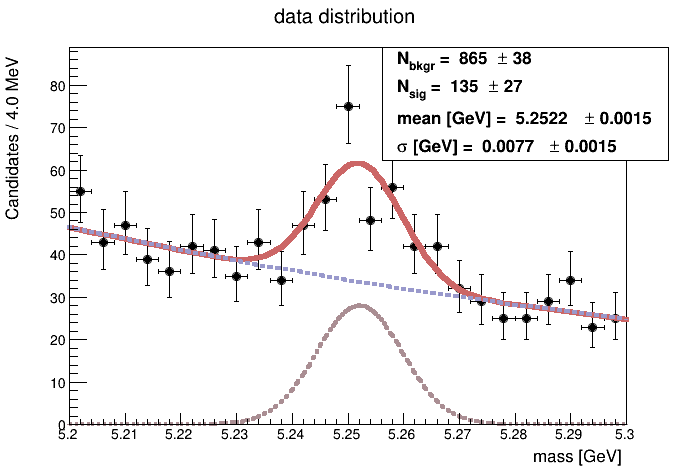

In [10]:
c = ROOT.TCanvas()
frame = DE.plot_on_frame('data distribution', plot_params=ROOT.RooArgSet(N_sig, N_bkgr, mean, sigma), nbins=25)
frame.Draw()
c.Draw()

#### **$\chi^2$ goodness-of-fit test + fit convergence status check**

After doing calling the ```fit()``` method a ```fit_status``` flag is set to reflect the fit convergence. The same thing holds for ```chi2_test_status``` after calling ```chi2_test()``` method. $0$ means that everything is OK, over than $0$ that there are some problems.

In [11]:
chi2_results = list(DE.chi2_test(pvalue_threshold=0.05, nbins=-1).values())[0]
print(f'chi2: {chi2_results[0]}\nndf: {chi2_results[1]}\np-value of chi2 test: {chi2_results[2]}\n')
print(f'fit status: {DE.fit_status}, chi2_test status: {DE.chi2_test_status}')

chi2: 39.78664688246834
ndf: 45
p-value of chi2 test: 0.6919098895469404

fit status: 0, chi2_test status: 0


#### **Make pull distribution for the fit**

One can also plot the pull distribution $\frac{data - model}{error(data)}$ to check that the model describes the data well. Normally, if data points are withing $3\sigma$ away from $0$, the fit is good.

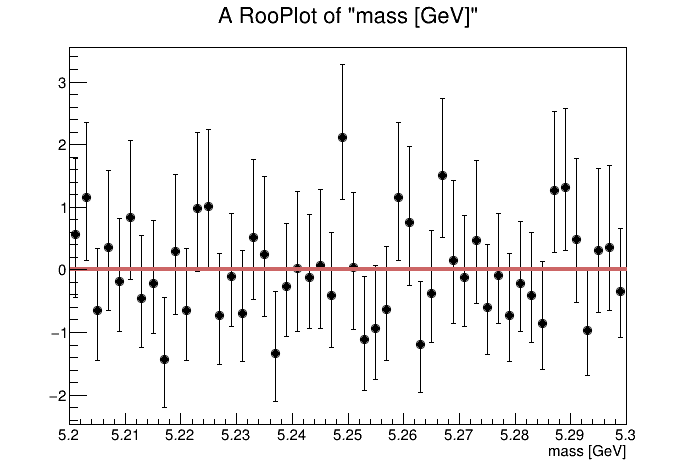

In [12]:
c_pull = ROOT.TCanvas()
frame_pull = DE.plot_pull()
frame_pull.Draw()
c_pull.Draw()

#### **Plot likelihood profiles**

It is possible to plot likelihoods for a give parameter of interest (e.g. number of signal events) and also a profiled to all nuisance parameters version. This might be useful to in checking the effect of systematics (by comparing profiled and nominal likelihoods) and estimating uncertainties of the parameters.

And this may take a while...

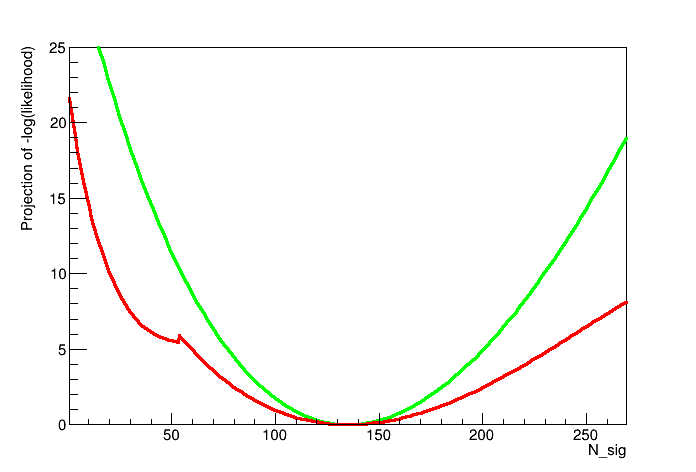

In [13]:
c_ll = ROOT.TCanvas()
frame_ll = DE.plot_ll(poi=N_sig)
frame_ll.Draw()
c_ll.Draw()

Yeah, this is a weird one

#### **Check whether there is bias in the fit**

Another important fit quality crosscheck is to generate toys from the fitted model and then fit each toy sample with the model which is to be checked. During this procedure the fit results (value and error) for the ```param_to_study``` will be aggregated and than shown as a histogram. The most informative plot is a pull histogram $\frac{\text{param}_{fit} - \text{param}_{true}}{\sigma(\text{param})}$ which under normal behaviour should be a Gaussian distributed with $\text{mean}=0$ and $\sigma=1$.

And this might take a while...

RooMCStudy: now generating 950 events
RooMCStudy: now generating 982 events
RooMCStudy: now generating 1007 events
RooMCStudy: now generating 1006 events
RooMCStudy: now generating 998 events
RooMCStudy: now generating 952 events
RooMCStudy: now generating 1027 events
RooMCStudy: now generating 1016 events
RooMCStudy: now generating 1008 events
RooMCStudy: now generating 1015 events
RooMCStudy: now generating 1007 events
RooMCStudy: now generating 989 events
RooMCStudy: now generating 1030 events
RooMCStudy: now generating 992 events
RooMCStudy: now generating 998 events
RooMCStudy: now generating 1022 events
RooMCStudy: now generating 989 events
RooMCStudy: now generating 965 events
RooMCStudy: now generating 1025 events
RooMCStudy: now generating 974 events
RooMCStudy: now generating 1001 events
RooMCStudy: now generating 994 events
RooMCStudy: now generating 985 events
RooMCStudy: now generating 998 events
RooMCStudy: now generating 959 events
RooMCStudy: now generating 983 events
R

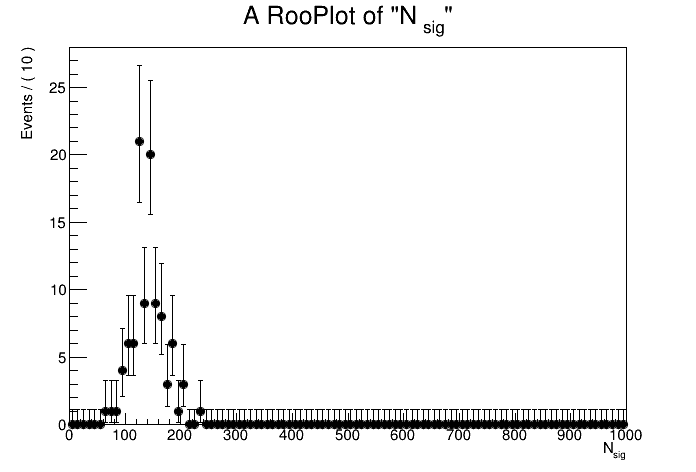

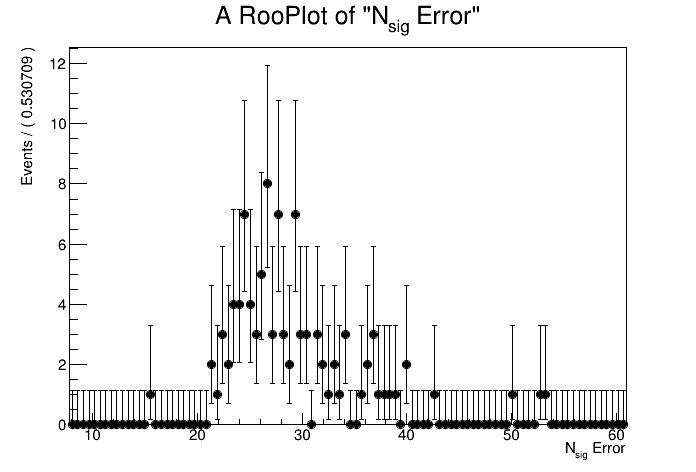

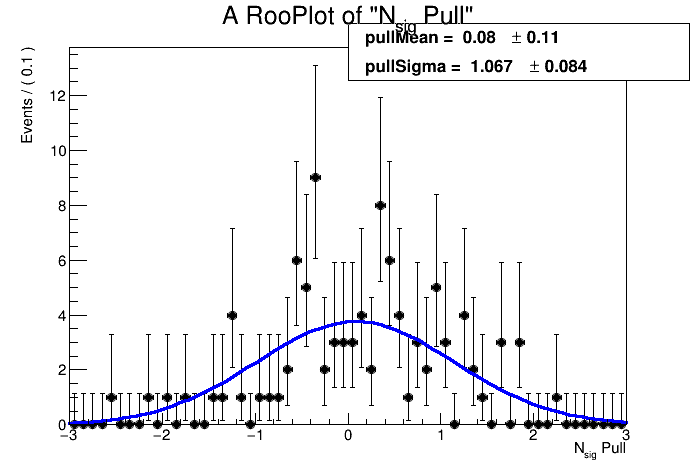

In [14]:
frame_var, frame_err, frame_pull = DE.check_fit_bias(param_to_study=N_sig, N_toys=100, verbose=False)
c_var = ROOT.TCanvas()
frame_var.Draw()
c_error = ROOT.TCanvas()
frame_err.Draw()
c_pull = ROOT.TCanvas()
frame_pull.Draw()

c_var.Draw()
c_error.Draw()
c_pull.Draw()

#### #1 **Calculate statistical significance of signal observation**

There are two methods to calculate significance of the observation. Both use loglikelihood ratio as a test statistic and its asymptotic $\chi^2$ approximation. The first one is implemented with a RooStats' ```AsymptoticCalculator()```, the second one is written by hand (and allows for more fit control) with calculating loglikelihoods and using some formulas to get the p-value. For more details on theory please have a look at [this must-read paper](https://arxiv.org/abs/1007.1727) and the source code for the details of implementation.

Statistical methods as input mostly need a  ```RooWorkspace()``` object which stores the data and the model. The latter can be exported from the ```DataExplorer()``` instance with a ```write_to_workspace()``` method.

In [15]:
w = DE.write_to_workspace(poi=N_sig, nuisances= [exp_par, mean, sigma, N_bkgr])

In [16]:
asympt_rrr = DE.asympt_signif(w=w)

AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 N_bkgr       7.70424e+02  5.85284e+01    0.00000e+00  1.00000e+03
     2 N_sig        1.84587e+02  5.33334e+01    0.00000e+00  1.00000e+03
     3 exp_par     -1.02722e+01  1.89170e+00   -5.00000e+01  1.00000e+00
     4 mean         5.25347e+00  2.85313e-03    5.20000e+00  5.30000e+00
     5 sigma        1.44896e-02  3.23534e-03    1.00000e-03  5.00000e-02
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           0
 **********
 **********
 **    5 **SET STR           1
 **********
 **********
 **    6 **MIGRAD        2500           1
 **********
 MIGRAD MINIMIZATION HAS CONVERGED.
 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.
 FCN=-8243.27 FROM MIGRAD    STATU

#### #2 **Calculate statistical significance of signal observation**

Another method, might be useful to crosscheck the p-values or tune the fit procedure.

In [17]:
ar_dict = DE.asympt_signif_ll(w=w)
for key, value in ar_dict.items():
    print(f'{key} = {value}')
print()

P = 2.292200049095311e-11
S = 6.68608494665314
nll_sig = -8243.26953651215
nll_null = -8220.91767055522


  RooFitResult: minimized FCN value: -8243.27, estimated distance to minimum: 4.55297e-06
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                N_bkgr    8.6510e+02 +/-  3.80e+01
                 N_sig    1.3490e+02 +/-  2.68e+01
               exp_par   -6.2611e+00 +/-  1.25e+00
                  mean    5.2522e+00 +/-  1.51e-03
                 sigma    7.6924e-03 +/-  1.47e-03


  RooFitResult: minimized FCN value: -8220.92, estimated distance to minimum: 1.01788e-05
                covariance matrix quality: Approximation only, not accurate
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
         

#### #3 **Calculate signal significance with toys**

Asymptotic methods are fast due to their closed-form solution and quite precise in the limit of large number of events. However, they are hardly reliable if the number of observed events is small (~10), since the $\chi^2$ approximation of the test statistic does not hold anymore. The way out to get the distribution of the test statistic under the null hypothesis is to generate toys from the null hypothesis (background only model) and repeatedly calculate and accumulate the values of the test statistic, which is by default a loglikelihood ratio where likelihoods are maximised to data under the corresponding hypothesis.

$$t = -2 \log(\dfrac{\text{L}(\vec{x}|\text{H}_1)}{\text{L}(\vec{x}|\text{H}_0)})$$

This method is the most reliable when it comes to calculating p-values, but very slow, prone to statistical uncertainties and at times useless when it comes to estimating really small p-values - it will take long long time to reach the level of $5\sigma$ without special tricks. That is why note that the returned p-value might be zero since if bkgr hypo is very unlikely it might require lots of toys to get to the observed value of test statistic.

So this may take a while...

    ----> Doing a re-scan first
    ----> Doing a re-scan first
    ----> Doing a re-scan first
    ----> Doing a re-scan first

Results HypoTestCalculator_result: 
 - Null p-value = 0 +/- 0
 - Significance = inf +/- -nan sigma
 - Number of Alt toys: 10
 - Number of Null toys: 100
 - Test statistic evaluated on data: 43.217
 - CL_b: 0 +/- 0
 - CL_s+b: 0.2 +/- 0.126491
 - CL_s: Error: Cannot compute CLs because CLb = 0. Returning CLs = -1
-1 +/- -1


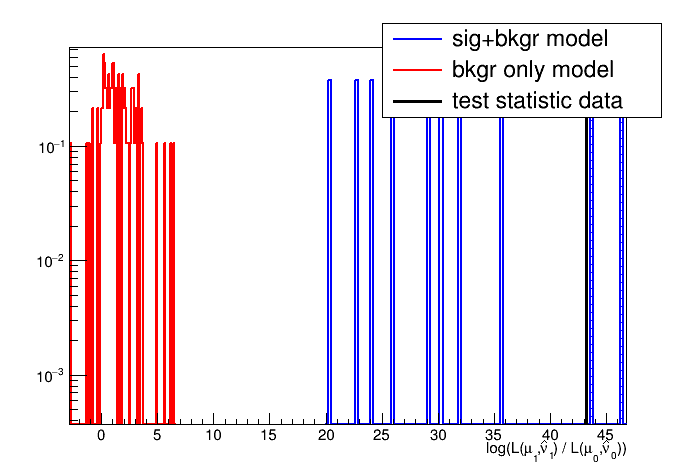

In [18]:
c_toy_signif = ROOT.TCanvas()
frame_toy_signif, _ = DE.toy_signif(w, n_toys_null = 100, n_toys_alt=10)
frame_toy_signif.Draw()
c_toy_signif.Draw()